<a href="https://colab.research.google.com/github/Polqer/diplommel1/blob/main/2attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet-pytorch
!git clone https://github.com/Polqer/diplommel1.git
!pip install torchcam


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=369f67097969894d62e234e247262126814dfd38d5010c128

In [ ]:
!pip install torchcam


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda:0
GPU: Tesla T4
Loaded pretrained weights for efficientnet-b0
Epoch 0/9
----------
train Loss: 1.1908 Acc: 0.2511
val Loss: 4.0295 Acc: 0.4407
Epoch 1/9
----------
train Loss: 0.3328 Acc: 0.4372
val Loss: 4.0295 Acc: 0.4407
Epoch 2/9
----------
train Loss: 0.1537 Acc: 0.4719
val Loss: 2.5174 Acc: 0.4068
Epoch 3/9
----------
train Loss: 0.0763 Acc: 0.4632
val Loss: 0.5693 Acc: 0.2373
Epoch 4/9
----------
train Loss: 0.0559 Acc: 0.4848
val Loss: 0.0000 Acc: 0.4576
Epoch 5/9
----------
train Loss: 0.0382 Acc: 0.5325
val Loss: 0.0000 Acc: 0.2881
Epoch 6/9
----------
train Loss: 0.0324 Acc: 0.4589
val Loss: 0.0000 Acc: 0.2712
Epoch 7/9
----------
train Loss: 0.0246 Acc: 0.5844
val Loss: 0.0000 Acc: 0.2712
Epoch 8/9
----------
train Loss: 0.0188 Acc: 0.5152
val Loss: 0.0000 Acc: 0.2881
Epoch 9/9
----------
train Loss: 0.0128 Acc: 0.5541
val Loss:

Epoch,▁▂▃▃▄▅▆▆▇█
Val Accuracy,▇▇▆▁█▃▂▂▃▄
Val Loss,██▅▂▁▁▁▁▁▁
Val accuracy,▇▇▆▁█▃▂▂▃▄
Val macro/f1,▁▁▁▁█▄▂▂▄▇
Val macro/precision,▁▁▁▄▆▇▃▃▆█
Val macro/recall,▅▅▄▁█▃▅▂▅▇
Val micro/f1,▇▇▆▁█▃▂▂▃▄
Val micro/precision,▇▇▆▁█▃▂▂▃▄
Val micro/recall,▇▇▆▁█▃▂▂▃▄
Val micro/roc_auc_score,█▂▃▂▄▄▁▁▂▆


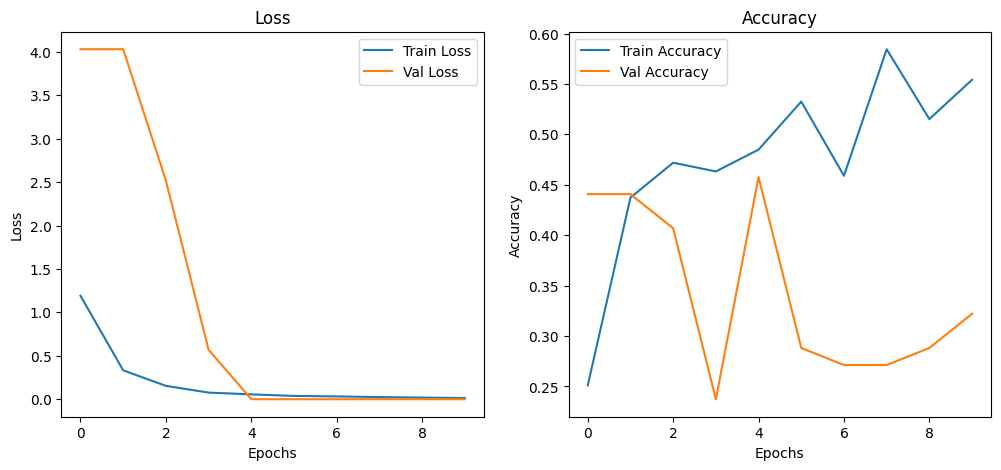

In [ ]:
import time
import copy
import torch

import numpy as np
import matplotlib.pyplot as plt
import gc
import torch.nn as nn
import wandb
import torch.optim as optim
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from scipy.io import loadmat
from pathlib import Path
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from google.colab import drive
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")


train_dir = '/content/diplommel1/datamat/train'
val_dir = '/content/diplommel1/datamat/test'

wandb.init(project="my-awesome-project", name= "matEfficientnet")

batch_size = 16
num_epochs = 10
learning_rate = 0.0001
input_size = (16, 256, 256)  # (каналы, высота,ширина)
num_classes = 3  # "mm", "nn", "other"



#т.к. данные являются несбалансированными Focal Loss уменьшает влияние легко классифицируемых примеров и делает модель более чувствительной к сложным случаям
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, num_classes=3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, 1e-7, 1 - 1e-7)  # Чтобы избежать логарифмирования 0
        targets = torch.eye(self.num_classes).to(inputs.device).index_select(dim=0, index=targets)  # Преобразуем метки в one-hot
        cross_entropy_loss = -targets * torch.log(inputs)
        loss = self.alpha * torch.pow(1 - inputs, self.gamma) * cross_entropy_loss
        return loss.sum(dim=1).mean()  # Среднее по батчу

#датасет
class HyperspectralDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)  #Путь к корню директории с данными
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])  #Список классов из папок
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  #Индексация классов
        self.files = []

#Проходим по всем классам и добавляем файлы
        for cls_name in self.classes:
            class_dir = self.root_dir / cls_name
            for file_path in class_dir.glob("*.mat"):  # Поиск .mat файлов в каждой папке
                self.files.append((file_path, self.class_to_idx[cls_name]))  # Добавляем файл и метку

    def __len__(self):
        return len(self.files)  #Возвращаем общее количество файлов

    def __getitem__(self, idx):
        file_path, label = self.files[idx]  #Получаем путь к файлу и метку класса
        mat_data = loadmat(file_path)  #Загружаем данные из .mat файла

        #Проверка наличия ожидаемого ключа в файле
        if 'DataCubeC' not in mat_data:
            raise KeyError(f"Ключ 'DataCubeC' не найден в файле {file_path}")

        #Получаем изображение
        image = mat_data['DataCubeC']
        image = np.transpose(image, (2, 0, 1))  #Преобразуем в формат (channels, height, width)
        #Преобразуем изображение в тензор PyTorch
        image = torch.tensor(image, dtype=torch.float32)
        #применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label
#Модель с EfficientNet3D EfficientNet предназначен для работы с трёхмерными (3D) данными, например:
# Медицинские изображения (MRI, CT, гиперспектральные кубы) Видео (кадры как временные слои)

class EfficientNet3D(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet3D, self).__init__()


        self.model = EfficientNet.from_pretrained('efficientnet-b0')

        #Изменяем первый слой свертки, чтобы принимать 16 каналов
        in_channels = 16  #Количество каналов моих гиперспектральных изображениях
        self.model._conv_stem = nn.Conv2d(in_channels=in_channels,
                                          out_channels=self.model._conv_stem.out_channels,
                                          kernel_size=self.model._conv_stem.kernel_size,
                                          stride=self.model._conv_stem.stride,
                                          padding=self.model._conv_stem.padding,
                                          bias=False)

        #Заменяем последний слой для классификации 3-х классов
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

#Расчет метрик
def calculate_metrics(y_true, y_pred, y_true_proba, y_pred_proba):
    return {
        'accuracy': accuracy_score(y_true=y_true, y_pred=y_pred),
        'confusion_matrix': confusion_matrix(y_true=y_true, y_pred=y_pred),
        'micro/precision': precision_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0),
        'micro/recall': recall_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0),
        'micro/f1': f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0),
        'micro/roc_auc_score': roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro'),
        'macro/precision': precision_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0),
        'macro/recall': recall_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0),
        'macro/f1': f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0),
        'roc_auc_score':  roc_auc_score(y_true=y_true_proba, y_score=y_pred_proba, average=None, multi_class='ovr'),
        'weighted/precision': precision_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0),
        'weighted/recall': recall_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0),
        'weighted/f1': f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)
    }


# Трансформации
transform = transforms.Compose([transforms.Normalize(mean=[0.5], std=[0.5])])

# Загрузка данных
train_dataset = HyperspectralDataset(train_dir, transform=transform)
val_dataset = HyperspectralDataset(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Инициализация модели
model = EfficientNet3D(num_classes=num_classes).to(device)

# Функция потерь и оптимизатор
criterion = FocalLoss(gamma=2.0, alpha=0.25, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Функция обучения
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # История обучения
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}\n' + '-' * 10)

        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            is_train = phase == 'train'
            model.train(is_train)

            running_loss = 0.0
            running_corrects = 0

            all_labels, all_preds, all_true_proba, all_pred_proba = [], [], [], []

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(is_train):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy()

                    if is_train:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_true_proba.extend(np.eye(outputs.shape[1])[labels.cpu().numpy()])
                all_pred_proba.extend(probabilities)

            # Средние значения за эпоху
            dataset_size = len(loader.dataset)
            epoch_loss = running_loss / dataset_size
            epoch_acc = (running_corrects.double() / dataset_size).item()

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                # Вычисление метрик
                try:
                    metrics = calculate_metrics(
                        y_true=all_labels,
                        y_pred=all_preds,
                        y_true_proba=np.array(all_true_proba),
                        y_pred_proba=np.array(all_pred_proba)
                    )
                    wandb.log({
                        "Val Loss": epoch_loss,
                        "Val Accuracy": epoch_acc,
                        **{f"Val {k}": v for k, v in metrics.items() if k != 'confusion_matrix'},
                        "Epoch": epoch
                    })
                except Exception as e:
                    print(f"Ошибка при расчете метрик: {e}")

                # Обновление лучшей модели
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        torch.cuda.empty_cache()
        gc.collect()

    # Время обучения
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["val_loss"], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # График Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.plot(history["val_acc"], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')



    return model
# Вызов функции обучения
train_model(model, criterion, optimizer, num_epochs)
wandb.finish()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from scipy.io import loadmat
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from PIL import Image
class EfficientNet1C(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet1C, self).__init__()

        self.model = EfficientNet.from_pretrained('efficientnet-b0')

        # Изменяем первый слой на 1 канал
        in_channels = 1
        self.model._conv_stem = nn.Conv2d(in_channels=in_channels,
                                          out_channels=self.model._conv_stem.out_channels,
                                          kernel_size=self.model._conv_stem.kernel_size,
                                          stride=self.model._conv_stem.stride,
                                          padding=self.model._conv_stem.padding,
                                          bias=False)

        # Выходной слой на 3 класса
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Создаём модель
num_classes = 3
model = EfficientNet1C(num_classes).to(device)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Функция загрузки изображения
def load_mat_image(file_path):
    mat_data = loadmat(file_path)
    if 'DataCubeC' not in mat_data:
        raise KeyError(f"Ключ 'DataCubeC' не найден в файле {file_path}")

    image = mat_data['DataCubeC']  # Извлекаем гиперспектральный куб
    image = np.transpose(image, (2, 0, 1))  # Переставляем оси: (каналы, высота, ширина)
    image = torch.tensor(image, dtype=torch.float32)  # Преобразуем в тензор PyTorch
    return image

# Путь к изображению
image_path = '/content/diplommel1/datamat/train/DNcube/101.mat'
image = load_mat_image(image_path)

# Оставляем только 1 канал (например, первый)
image = image[:1, :, :]  # (1, H, W)

# Добавляем размерность батча
image = image.unsqueeze(0).to(device)  # (1, 1, H, W)

# Определение модели EfficientNet с 16 каналами
class EfficientNet3D(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet3D, self).__init__()

        self.model = EfficientNet.from_pretrained('efficientnet-b0')

        # Изменяем первый сверточный слой
        in_channels = 16  # Гиперспектральные изображения
        self.model._conv_stem = nn.Conv2d(in_channels=in_channels,
                                          out_channels=self.model._conv_stem.out_channels,
                                          kernel_size=self.model._conv_stem.kernel_size,
                                          stride=self.model._conv_stem.stride,
                                          padding=self.model._conv_stem.padding,
                                          bias=False)

        # Заменяем последний слой для 3 классов
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Создаём модель
num_classes = 3
model = EfficientNet3D(num_classes).to(device)
model.eval()

# Выбираем слой для Grad-CAM
target_layer = model.model._conv_head  # Последний сверточный слой

# Инициализируем Grad-CAM
cam_extractor = GradCAM(model, target_layer=model.model._conv_head)

# Пропускаем изображение через модель
output = model(image)
class_idx = output.argmax(dim=1).item()  # Получаем индекс предсказанного класса

# Получаем карту активации
activation_map = cam_extractor(class_idx, output)

# Преобразуем тензоры в numpy
activation_map = activation_map[0].cpu().detach().numpy()
image_np = image[0, 0].cpu().numpy()  # Берём 1 канал для наложения

# **Исправляем ошибку: нормализуем в 0-255 и конвертируем в `PIL.Image`**
image_pil = Image.fromarray((image_np * 255).astype(np.uint8), mode="L")  # "L" = градации серого
activation_pil = Image.fromarray((activation_map * 255).astype(np.uint8), mode="L")

# Накладываем карту активации
overlay = overlay_mask(image_pil.convert("RGB"), activation_pil.convert("RGB"))

# Отображаем результат
plt.imshow(overlay)
plt.axis('off')
plt.show()


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


RuntimeError: Given groups=1, weight of size [32, 16, 3, 3], expected input[1, 1, 272, 512] to have 16 channels, but got 1 channels instead